# Implementing CRISP-DM Methodology

<img src='https://imgs.search.brave.com/xJ5euW0KJqvoedGH2o3aL7vKBx-qDSN5659B5iCA5Ds/rs:fit:860:0:0/g:ce/aHR0cHM6Ly91cGxv/YWQud2lraW1lZGlh/Lm9yZy93aWtpcGVk/aWEvY29tbW9ucy9i/L2I5L0NSSVNQLURN/X1Byb2Nlc3NfRGlh/Z3JhbS5wbmc'
height = '40%' width = '40%'>


# Importing Datasets from Google Drive link

gdown library is specifically designed to download files from Google Drive links only

If you want to keep the downloaded file into a specific folder:

In [5]:
import os
import gdown

# Original Google Drive URL and file ID
original_url = 'https://drive.google.com/file/d/1lSVE0gBQChGBvjVjNbf6ewDO7pJ7Q2zU/view?usp=sharing'
file_id = "1lSVE0gBQChGBvjVjNbf6ewDO7pJ7Q2zU"

# Constructing the download URL
url = f'https://drive.google.com/uc?id={file_id}'

# Define the output directory path
output_dir = '../artifacts'

# Ensure that the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Specify the output file path
output_path = os.path.join(output_dir, 'crow_sparrow_eagle_dove_pigeon_datasets.zip')  # Replace 'downloaded_file.ext' with the desired file name and extension

# Download the file to the specified output path
gdown.download(url, output=output_path, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1lSVE0gBQChGBvjVjNbf6ewDO7pJ7Q2zU
From (redirected): https://drive.google.com/uc?id=1lSVE0gBQChGBvjVjNbf6ewDO7pJ7Q2zU&confirm=t&uuid=788f4d1d-b707-49f6-b82f-a19341443786
To: /opt/davidthapa/Documents/Multi-Classification-of-Bird-Species/artifacts/crow_sparrow_eagle_dove_pigeon_datasets.zip
100%|██████████| 68.5M/68.5M [00:10<00:00, 6.33MB/s]


'../artifacts/crow_sparrow_eagle_dove_pigeon_datasets.zip'

## Extracting datasets

In [6]:
import zipfile
zip_ref = zipfile.ZipFile('../artifacts/crow_sparrow_eagle_dove_pigeon_datasets.zip','r')
zip_ref.extractall('../artifacts')
zip_ref.close()

# Importing Library

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing import image
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix

%matplotlib inline


# Goal | Business Understanding

- To develop a Deep Learning model to automatically classify species of birds from different species.

# Success Criteria | Business Understanding

- accuracy > 90%,
- val_accuracy > 90%,
- precision > 90%,
- recall > 90%.

# Data Sources and Collection | Business Understanding

- Source: Drive
- Collection: https://drive.google.com/file/d/1lSVE0gBQChGBvjVjNbf6ewDO7pJ7Q2zU/view?usp=sharing


# Dataset Description | Data Understanding

This dataset consists of 2970 images divided into 22 target classes, with each category containing 130 images of shape 224*224. The 22 different classes of this dataset are:

|class_name|class_label|
|----------|-----------|
|BALD EAGLE|0|
|BLACK-THROATED SPARROW|1|
|CHIPPING SPARROW|2|
|CRESTED SERPENT EAGLE|3|
|CROW|4|
|EUROPEAN TURTLE DOVE|5|
|FRILL BACK PIGEON|6|
|GOLDEN EAGLE|7|
|GREEN WINGED DOVE|8|
|GREY HEADED FISH EAGLE|9|
|HARPY EAGLE|10|
|HOUSE SPARROW|11|
|JACOBIN PIGEON|12|
|JAVA SPARROW|13|
|MOURNING DOVE|14|
|NICOBAR PIGEON|15|
|ORNATE HAWK EAGLE|16|
|PHILIPPINE EAGLE|17|
|ROCK DOVE|18|
|SCARLET CROWNED FRUIT DOVE|19|
|VICTORIA CROWNED PIGEON|20|
|ZEBRA DOVE|21|

This dataset is a subcategory of main dataset. Since, this dataset is made according to my needs. It is available through google drive link . We need to download it before proceding deeper.

# Exploratory Image Analysis | Data Understanding

**Visualization:**

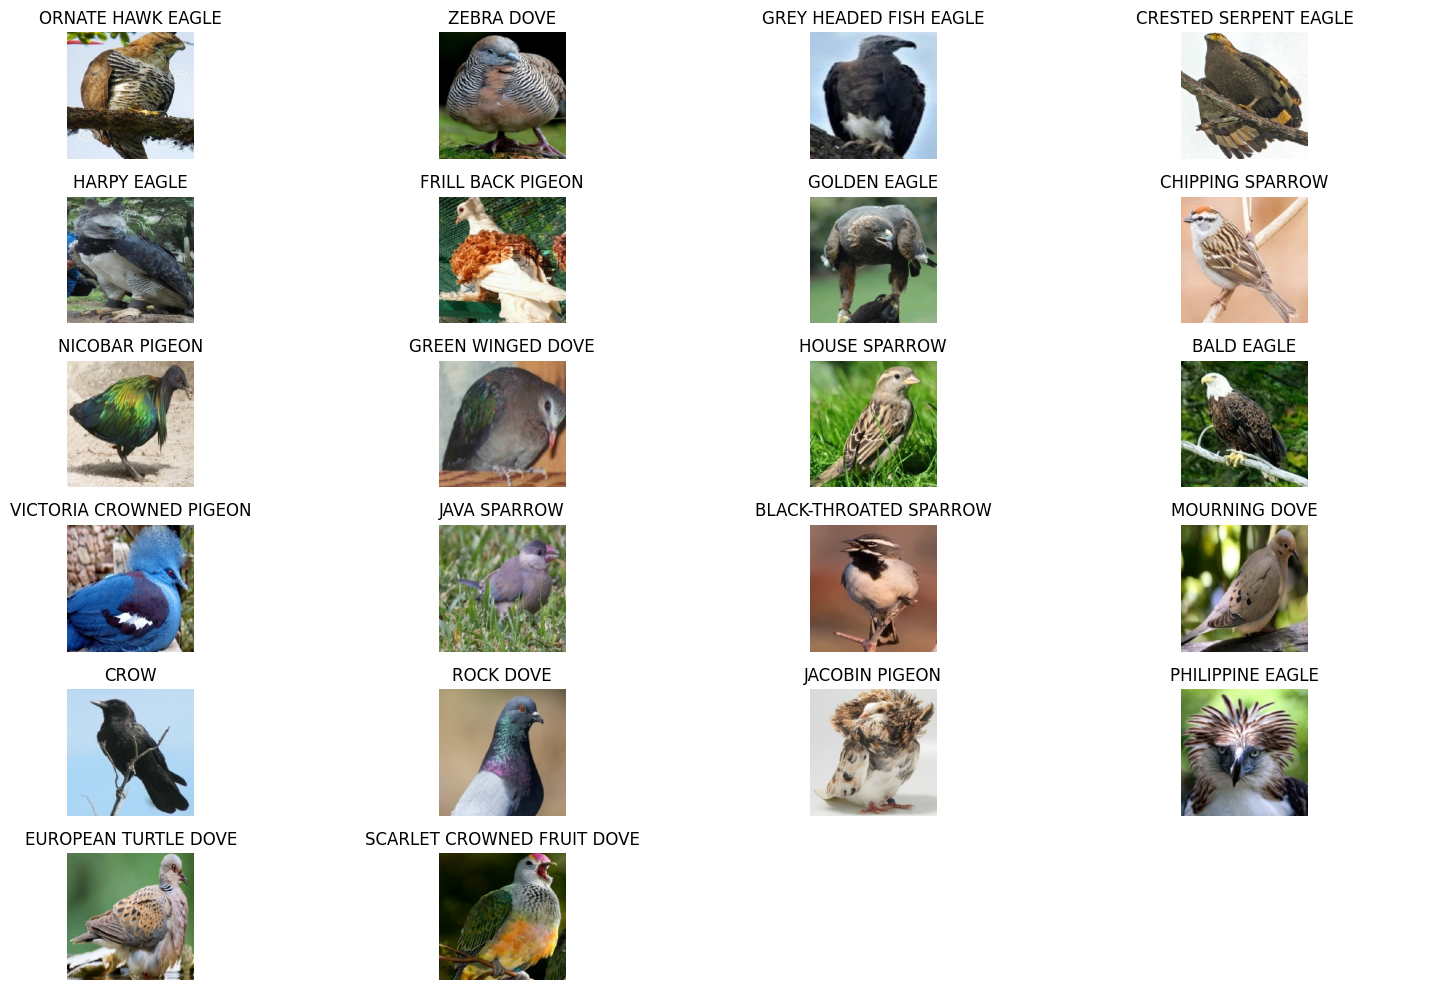

In [5]:
folders = [f.path for f in os.scandir('/content/dataset/train') if f.is_dir()]

# Determine the number of rows and columns for subplots
num_rows = 6
num_cols = 4

# Create subplots with larger figure size
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

# Flatten the axes for easy iteration
ax = ax.flatten()

for i, folder in enumerate(folders):
    # Get a list of image files within the folder
    image_files = [f.path for f in os.scandir(folder) if f.is_file() and f.name.endswith(('.jpg', '.jpeg', '.png'))]

    # Take the first image from the folder
    if image_files:
        img_path = image_files[0]  # Take the first image
        img = image.load_img(img_path, target_size=(400, 400))  # Load and resize the image
        ax[i].imshow(img)  # Display the image
        ax[i].set_title(os.path.basename(folder))  # Set the title as the folder name
        ax[i].axis('off')  # Turn off axis labels

# Hide any remaining empty subplots
for j in range(len(folders), num_rows * num_cols):
    ax[j].axis('off')

plt.tight_layout()  # Adjust layout
plt.show()  # Show the plot


# Image Properties

In [8]:
img_width=224
img_height=224
img_size=(img_width,img_height)
img_channels=3

# Applying Data Augmentation

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    rotation_range = 15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '../artifacts/dataset/train',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    seed = 123,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    '../artifacts/dataset/test',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    seed = 123,
    shuffle=False
)

Found 2860 images belonging to 22 classes.
Found 110 images belonging to 22 classes.


**Data Distribution:**

While training a Deep Learning Model, datasets should always be equal to eachother i.e no imbalance in data

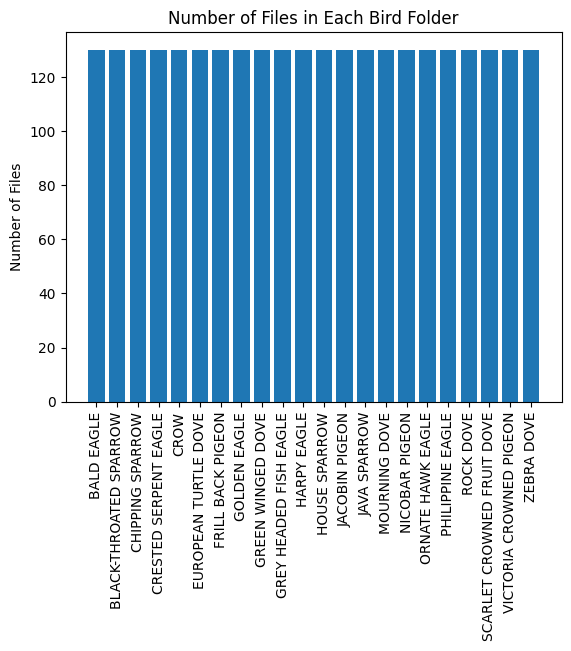

In [8]:
root_folder = '/content/dataset/train'
subdirectories = os.listdir(root_folder)
nspecies = [len(os.listdir(os.path.join(root_folder, str(file)))) for file in sorted(subdirectories)]

class_names = list(train_generator.class_indices.keys())

plt.bar(class_names,nspecies)
plt.xticks(rotation='vertical')
plt.ylabel("Number of Files")
plt.title("Number of Files in Each Bird Folder")
plt.show()



# Defining Model | Modelling

In [9]:
reg_strength = 0.001
model = Sequential([
    Conv2D(32,kernel_size = (3,3), padding = "valid", activation = "relu", input_shape =(img_width,img_height,img_channels), kernel_regularizer=l2(reg_strength)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2),strides = 2,padding = "valid"),

    Conv2D(64,kernel_size = (3,3), padding = "valid", activation = "relu", kernel_regularizer=l2(reg_strength)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2),strides = 2,padding = "valid"),

    Conv2D(128,kernel_size = (3,3), padding = "valid", activation = "relu", kernel_regularizer=l2(reg_strength)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2),strides = 2,padding = "valid"),

    Flatten(),

    Dense(512,activation = 'relu', kernel_regularizer=l2(reg_strength)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128,activation = 'relu', kernel_regularizer=l2(reg_strength)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(22, activation = "softmax")
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                        

In [11]:
optimizer = Adam(learning_rate = 0.005)
model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [12]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    verbose = 1,
    restore_best_weights = True
)

In [13]:
lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 2,
    verbose = 1,
    min_lr = 1e-6
)

In [14]:
mc = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [15]:
callbacks = [early_stopping,lr_scheduler,mc]

In [16]:
epochs=100

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 22.9029 - accuracy: 0.1818

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 55s 453ms/step - loss: 22.9029 - accuracy: 0.1818 - val_loss: 17.6536 - val_accuracy: 0.0455 - lr: 0.0050
Epoch 2/100
90/90 [==============================] - 42s 468ms/step - loss: 9.6242 - accuracy: 0.2713 - val_loss: 8.2648 - val_accuracy: 0.0545 - lr: 0.0050
Epoch 3/100
90/90 [==============================] - 42s 466ms/step - loss: 5.7938 - accuracy: 0.3332 - val_loss: 6.2248 - val_accuracy: 0.1091 - lr: 0.0050
Epoch 4/100
90/90 [==============================] - 42s 471ms/step - loss: 4.7434 - accuracy: 0.3657 - val_loss: 6.0426 - val_accuracy: 0.1545 - lr: 0.0050
Epoch 5/100
90/90 [==============================] - 42s 467ms/step - loss: 4.7404 - accuracy: 0.3885 - val_loss: 4.8677 - val_accuracy: 0.3273 - lr: 0.0050
Epoch 6/100
90/90 [==============================] - 42s 467ms/step - loss: 5.0320 - accuracy: 0.4014 - val_loss: 4.9305 - val_accuracy: 0.5000 - lr: 0.0050
Epoch 7/100
90/90 [==============================] - ETA: 0s - loss:

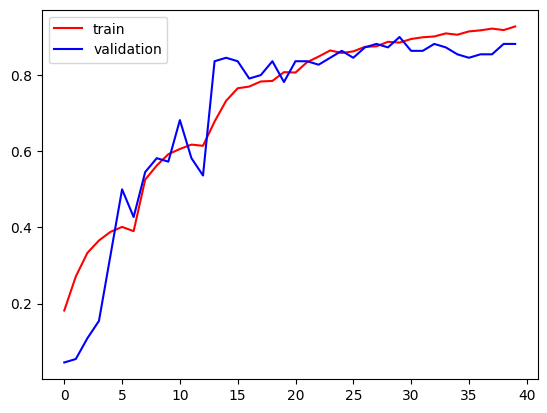

In [17]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color = 'blue',label='validation')
plt.legend()
plt.show()

# Testing | Evaluation

In [18]:
# Generate predictions on the test set
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
print(y_pred)

4/4 [==============================] - 0s 41ms/step
[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  5  3  6  4  4  4  4
  4  5  5  5  5  5 10  6  6  6  6  7  7  7  7  7  8  8 19  8  8  9  9  9
  9  9 10 10 18 10 10 11  5 11 11 11  4  6 12  4 12 13 13 13 13 13 14 14
 14 14 14 15 15 15 15 15  0 16 16 16 16 17 17 17 17 17 18 18 18 21 18 19
 19 19 19 19 20 20 20 20 20 21 21 21 21 21]


In [19]:
# True Values
y_actual = validation_generator.classes
print(y_actual)

[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14
 14 14 14 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21 21 21 21]


In [21]:
precision = precision_score(y_actual, y_pred, average='weighted')
recall = recall_score(y_actual, y_pred, average='weighted')

print(f"Precision: {precision} and Recall: {recall}")


Precision: 0.917965367965368 and Recall: 0.9


In [22]:
# Generate classification report
print(classification_report(y_actual, y_pred))


              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      0.60      0.75         5
           4       0.71      1.00      0.83         5
           5       0.71      1.00      0.83         5
           6       0.67      0.80      0.73         5
           7       1.00      1.00      1.00         5
           8       1.00      0.80      0.89         5
           9       1.00      1.00      1.00         5
          10       0.80      0.80      0.80         5
          11       1.00      0.80      0.89         5
          12       1.00      0.40      0.57         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      0.80      0.89         5
          17       1.00    

In [24]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_actual, y_pred)
print(conf_matrix)


[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0

## Import model

In [14]:
model_path = '../artifacts/Model:Birds_multiclassification.h5'

model = load_model(model_path)

2024-02-22 09:24:09.404873: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177209344 exceeds 10% of free system memory.
2024-02-22 09:24:09.496957: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177209344 exceeds 10% of free system memory.
2024-02-22 09:24:09.526585: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177209344 exceeds 10% of free system memory.
2024-02-22 09:24:20.593428: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177209344 exceeds 10% of free system memory.
2024-02-22 09:24:20.755505: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177209344 exceeds 10% of free system memory.


## Validating on New Data | Evaluation

In [15]:
def img_preprocess(img_path):
  img = load_img(img_path, target_size=(img_width, img_height))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /=255.
  return img_array


In [19]:
def pred_label(img_array):
    predicted = model.predict(img_array)
    predicted_class_index = np.argmax(predicted)

    # Map the predicted class index to class name
    class_indices = train_generator.class_indices
    class_names = list(class_indices.keys())
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

In [21]:
img_array = img_preprocess('../artifacts/dataset/train/JAVA SPARROW/004.jpg')

# Print the predicted class name
print(f'The predicted class is: {pred_label(img_array)}')

1/1 [==============================] - 0s 46ms/step
The predicted class is: JAVA SPARROW


1/1 [==============================] - 0s 33ms/step


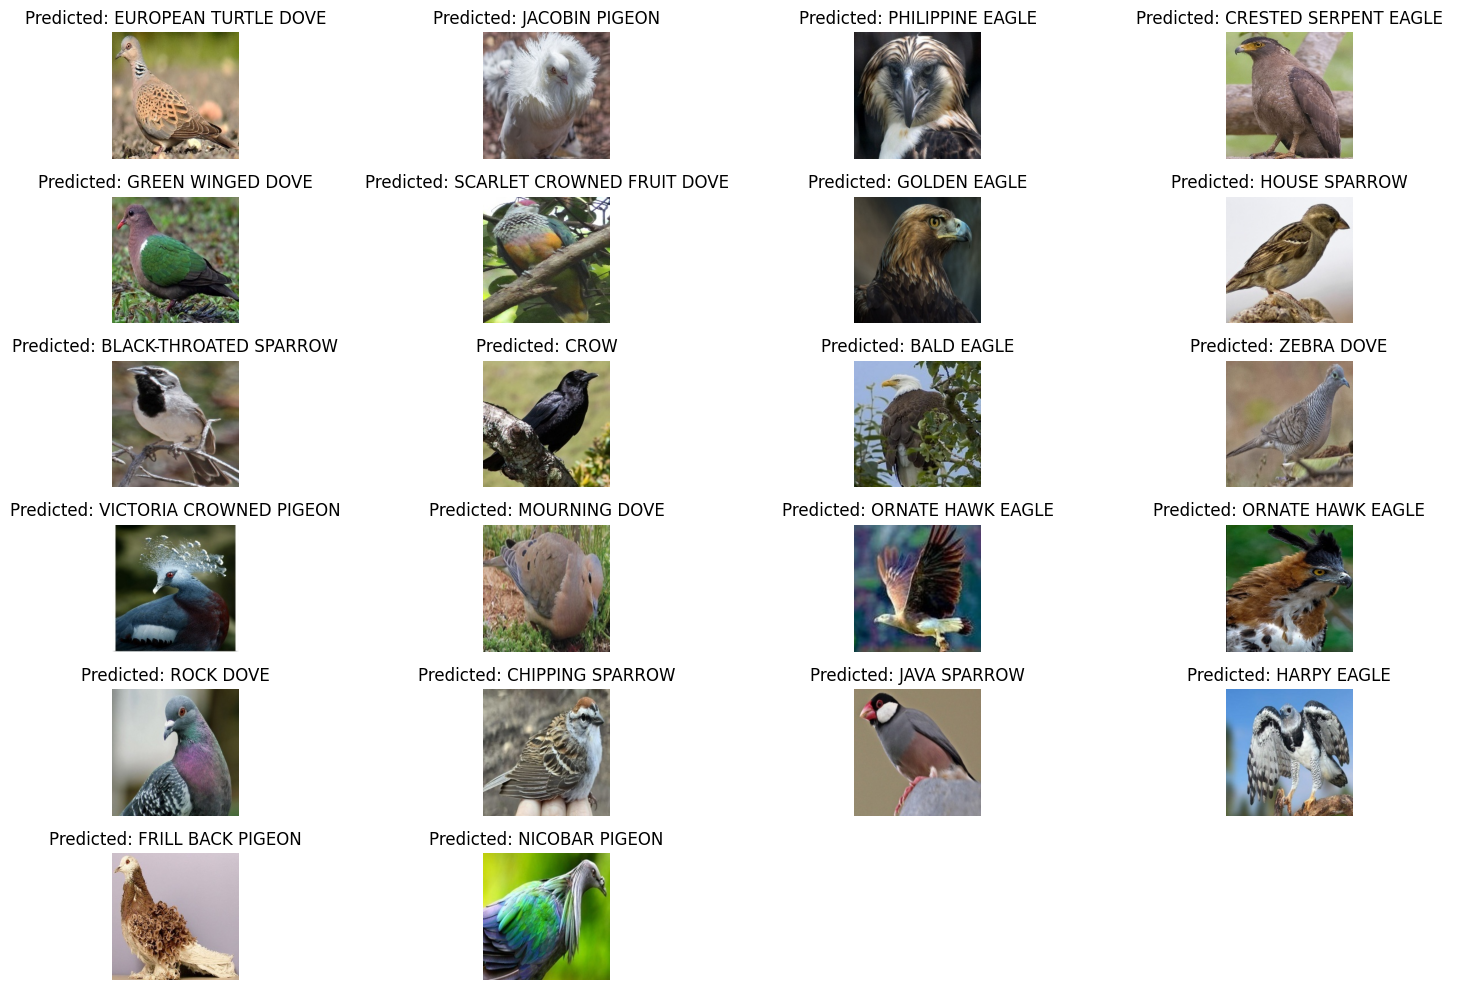

In [23]:
folders = [f.path for f in os.scandir('../artifacts/dataset/train') if f.is_dir()]

# Determine the number of rows and columns for subplots
num_rows = 6
num_cols = 4

# Create subplots with larger figure size
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

# Flatten the axes for easy iteration
ax = ax.flatten()

for i, folder in enumerate(folders):
    # Get a list of image files within the folder
    image_files = [f.path for f in os.scandir(folder) if f.is_file() and f.name.endswith(('.jpg', '.jpeg', '.png'))]

    # Take the first image from the folder
    if image_files:
        img_path = image_files[0]  # Take the first image
        img_array = img_preprocess(img_path)

        ax[i].imshow(img_array[0])  # Display the image

        #make prediction and show the results
        pred_class = pred_label(img_array)
        ax[i].set_title(f'Predicted: {pred_class}')

        ax[i].axis('off')  # Turn off axis labels

# Hide any remaining empty subplots
for j in range(len(folders), num_rows * num_cols):
    ax[j].axis('off')

plt.tight_layout()  # Adjust layout
plt.show()  # Show the plot
